In [9]:
import os
from pathlib import Path

DATA_PATH = r"C:\Users\ramya\Desktop\data science\predictive analysis\project CA2\archive (1)"

print("Checking folder structure...")
print("\nContents of main folder:")
for item in os.listdir(DATA_PATH):
    print(f"  - {item}")

train_folder = Path(DATA_PATH) / '38-Cloud_training'
if train_folder.exists():
    print("\n38-Cloud_training folder found")

Checking folder structure...

Contents of main folder:
  - 38-Cloud_95-Cloud_Test_Metadata_Files
  - 38-Cloud_test
  - 38-Cloud_training
  - 38-Cloud_Training_Metadata_Files
  - bibtex.txt
  - training_patches_38-cloud_nonempty.csv

38-Cloud_training folder found


In [38]:
"""
Cloud Cover Prediction from 38-Cloud Dataset using Classical Machine Learning
Dataset: 38-Cloud Landsat 8 satellite images
Approach: Patch-level classification using classical ML
"""

import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

class CloudCoverPredictor38:
    """Cloud cover prediction for 38-Cloud dataset using classical ML"""
    
    def __init__(self, data_path, image_size=(128, 128)):
        self.data_path = Path(data_path)
        self.image_size = image_size
        self.scaler = StandardScaler()
        self.label_encoder = LabelEncoder()
        self.models = {}
        self.best_model = None
        
    def load_multispectral_patch(self, patch_name, is_train=True):
        """Load a single patch with all 4 bands (Red, Green, Blue, NIR)"""
        if is_train:
            base_path = self.data_path / '38-Cloud_training'
            
            # Convert red_patch name to other band names
            # red_patch_X... -> green_patch_X..., blue_patch_X..., etc.
            red_name = patch_name
            green_name = red_name.replace('red_patch', 'green_patch')
            blue_name = red_name.replace('red_patch', 'blue_patch')
            nir_name = red_name.replace('red_patch', 'nir_patch')
            gt_name = red_name.replace('red_patch', 'gt_patch')
            
            red_path = base_path / 'train_red' / red_name
            green_path = base_path / 'train_green' / green_name
            blue_path = base_path / 'train_blue' / blue_name
            nir_path = base_path / 'train_nir' / nir_name
            gt_path = base_path / 'train_gt' / gt_name
        else:
            base_path = self.data_path / '38-Cloud_test'
            red_name = patch_name
            green_name = red_name.replace('red_patch', 'green_patch')
            blue_name = red_name.replace('red_patch', 'blue_patch')
            nir_name = red_name.replace('red_patch', 'nir_patch')
            
            red_path = base_path / 'test_red' / red_name
            green_path = base_path / 'test_green' / green_name
            blue_path = base_path / 'test_blue' / blue_name
            nir_path = base_path / 'test_nir' / nir_name
            gt_path = None  # Test set doesn't have individual GT
        
        # Load each band
        try:
            red = cv2.imread(str(red_path), cv2.IMREAD_GRAYSCALE)
            green = cv2.imread(str(green_path), cv2.IMREAD_GRAYSCALE)
            blue = cv2.imread(str(blue_path), cv2.IMREAD_GRAYSCALE)
            nir = cv2.imread(str(nir_path), cv2.IMREAD_GRAYSCALE)
            
            if any(x is None for x in [red, green, blue, nir]):
                return None, None
            
            # Combine into 4-channel image
            multispectral = np.stack([red, green, blue, nir], axis=-1)
            
            # Load ground truth to determine label
            gt = cv2.imread(str(gt_path), cv2.IMREAD_GRAYSCALE) if gt_path and gt_path.exists() else None
            
            return multispectral, gt
        except Exception as e:
            return None, None
    
    def calculate_cloud_percentage(self, gt_mask):
        """Calculate cloud percentage from ground truth mask"""
        if gt_mask is None:
            return None
        
        # Assuming cloud pixels are white (255) and clear pixels are black (0)
        cloud_pixels = np.sum(gt_mask > 127)
        total_pixels = gt_mask.size
        cloud_percentage = (cloud_pixels / total_pixels) * 100
        
        return cloud_percentage
    
    def get_label_from_percentage(self, cloud_percentage):
        """Convert cloud percentage to categorical label"""
        if cloud_percentage is None:
            return None
        
        if cloud_percentage < 10:
            return 'clear'
        elif cloud_percentage < 40:
            return 'partly_cloudy'
        else:
            return 'cloudy'
    
    def extract_spectral_features(self, img):
        """Extract features from 4-band multispectral image"""
        features = []
        
        # Statistical features for each band
        for band_idx in range(4):
            band = img[:, :, band_idx]
            features.extend([
                np.mean(band),
                np.std(band),
                np.median(band),
                np.min(band),
                np.max(band),
                np.percentile(band, 25),
                np.percentile(band, 75)
            ])
        
        # Band ratios (useful for cloud detection)
        red = img[:, :, 0].astype(float)
        green = img[:, :, 1].astype(float)
        blue = img[:, :, 2].astype(float)
        nir = img[:, :, 3].astype(float)
        
        # NDVI (Normalized Difference Vegetation Index)
        ndvi = (nir - red) / (nir + red + 1e-10)
        features.extend([np.mean(ndvi), np.std(ndvi)])
        
        # NDWI (Normalized Difference Water Index)
        ndwi = (green - nir) / (green + nir + 1e-10)
        features.extend([np.mean(ndwi), np.std(ndwi)])
        
        # Cloud index (Blue/Red ratio)
        cloud_ratio = blue / (red + 1e-10)
        features.extend([np.mean(cloud_ratio), np.std(cloud_ratio)])
        
        return np.array(features)
    
    def extract_texture_features(self, img):
        """Extract texture features from multispectral image"""
        features = []
        
        # Use visible bands for texture
        gray = cv2.cvtColor(img[:, :, :3].astype(np.uint8), cv2.COLOR_RGB2GRAY)
        
        # Resize for faster processing
        if gray.shape[0] > 128:
            gray = cv2.resize(gray, self.image_size)
        
        # Edge detection
        edges = cv2.Canny(gray, 50, 150)
        features.append(np.sum(edges) / edges.size)
        
        # Gradient features
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        features.extend([
            np.mean(np.abs(sobelx)),
            np.std(sobelx),
            np.mean(np.abs(sobely)),
            np.std(sobely)
        ])
        
        # Texture variance
        features.append(np.var(gray))
        
        return np.array(features)
    
    def extract_all_features(self, img):
        """Combine all feature extraction methods"""
        spectral_feat = self.extract_spectral_features(img)
        texture_feat = self.extract_texture_features(img)
        
        return np.concatenate([spectral_feat, texture_feat])
    
    def prepare_dataset(self, use_csv=True, max_samples=None):
        """Load and prepare the 38-Cloud dataset"""
        all_features = []
        all_labels = []
        
        print("Loading 38-Cloud dataset...")
        
        # Load training patches
        train_folder = self.data_path / '38-Cloud_training'
        
        if use_csv and (train_folder / 'training_patches_38-Cloud_nonempty.csv').exists():
            # Use non-empty patches only
            csv_path = train_folder / 'training_patches_38-Cloud_nonempty.csv'
            df = pd.read_csv(csv_path)
            patch_names = df.iloc[:, 0].values
            print(f"Found {len(patch_names)} non-empty training patches in CSV")
        else:
            # List all patches from red band folder
            red_folder = train_folder / 'train_red'
            if red_folder.exists():
                patch_names = [f.name for f in red_folder.glob('*.TIF')]
                print(f"Found {len(patch_names)} training patches")
            else:
                print("Error: Could not find training data!")
                return None, None
        
        # Limit samples if specified (for testing)
        if max_samples:
            patch_names = patch_names[:max_samples]
            print(f"Limited to {max_samples} samples for testing")
        
        # Process each patch
        processed_count = 0
        for idx, patch_name in enumerate(patch_names):
            if idx % 100 == 0:
                print(f"Processing patch {idx}/{len(patch_names)}")
            
            # Load multispectral patch and ground truth
            ms_img, gt_mask = self.load_multispectral_patch(patch_name, is_train=True)
            
            if ms_img is None or gt_mask is None:
                continue
            
            # Calculate cloud percentage and get label
            cloud_pct = self.calculate_cloud_percentage(gt_mask)
            label = self.get_label_from_percentage(cloud_pct)
            
            if label is None:
                continue
            
            # Extract features
            features = self.extract_all_features(ms_img)
            all_features.append(features)
            all_labels.append(label)
            processed_count += 1
        
        print(f"\nSuccessfully processed {processed_count} patches")
        print(f"Unique labels: {set(all_labels)}")
        
        # Count samples per class
        for label in set(all_labels):
            count = all_labels.count(label)
            print(f"  {label}: {count} samples ({count/len(all_labels)*100:.1f}%)")
        
        # Convert to numpy arrays
        features_array = np.array(all_features)
        labels_array = np.array(all_labels)
        
        # Encode labels
        labels_encoded = self.label_encoder.fit_transform(labels_array)
        
        print(f"\nFeature matrix shape: {features_array.shape}")
        print(f"Labels shape: {labels_encoded.shape}")
        
        return features_array, labels_encoded
    
    def train_models(self, X_train, y_train):
        """Train multiple classical ML models"""
        
        models_config = {
            'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
            'SVM': SVC(kernel='rbf', random_state=42, probability=True),
            'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
            'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10)
        }
        
        print("\n" + "="*60)
        print("TRAINING MODELS")
        print("="*60)
        
        results = {}
        
        for name, model in models_config.items():
            print(f"\nTraining {name}...")
            model.fit(X_train, y_train)
            
            # Cross-validation score
            cv_scores = cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1)
            results[name] = {
                'model': model,
                'cv_mean': cv_scores.mean(),
                'cv_std': cv_scores.std()
            }
            print(f"{name} - CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
            
            self.models[name] = model
        
        # Select best model
        best_model_name = max(results, key=lambda x: results[x]['cv_mean'])
        self.best_model = self.models[best_model_name]
        print(f"\n✓ Best model: {best_model_name}")
        
        return results
    
    def evaluate_models(self, X_test, y_test):
        """Evaluate all trained models"""
        print("\n" + "="*60)
        print("MODEL EVALUATION RESULTS")
        print("="*60)
        
        for name, model in self.models.items():
            print(f"\n{name}:")
            print("-" * 40)
            y_pred = model.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            print(f"Accuracy: {accuracy:.4f}")
            print("\nClassification Report:")
            print(classification_report(y_test, y_pred, 
                                       target_names=self.label_encoder.classes_))
    
    def plot_confusion_matrix(self, X_test, y_test):
        """Plot confusion matrix for best model"""
        y_pred = self.best_model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.label_encoder.classes_,
                   yticklabels=self.label_encoder.classes_)
        plt.title('Confusion Matrix - Best Model')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.savefig('confusion_matrix.png', dpi=150, bbox_inches='tight')
        print("\n✓ Confusion matrix saved as 'confusion_matrix.png'")
        plt.show()
    
    def save_model(self, filename='cloud_model_38cloud.pkl'):
        """Save the best model"""
        model_data = {
            'model': self.best_model,
            'scaler': self.scaler,
            'label_encoder': self.label_encoder,
            'image_size': self.image_size
        }
        
        with open(filename, 'wb') as f:
            pickle.dump(model_data, f)
        print(f"\n✓ Model saved to {filename}")


def main():
    """Main execution function"""
    
    # Set your dataset path (where 38-Cloud_training and 38-Cloud_test folders are)
    DATA_PATH = r"C:\Users\ramya\Desktop\data science\predictive analysis\project CA2\archive (1)"  # Current directory
    
    print("="*60)
    print("CLOUD COVER PREDICTION - 38-CLOUD DATASET")
    print("Using Classical Machine Learning")
    print("="*60)
    
    # Initialize predictor
    predictor = CloudCoverPredictor38(DATA_PATH, image_size=(128, 128))
    
    # Prepare dataset (use max_samples=500 for quick testing, None for full dataset)
    features, labels = predictor.prepare_dataset(use_csv=True, max_samples=None)
    
    if features is None or len(features) == 0:
        print("Error: No data loaded! Please check your dataset path.")
        return
    
    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(
        features, labels, test_size=0.2, random_state=42, stratify=labels
    )
    
    print(f"\nDataset split:")
    print(f"  Training samples: {len(X_train)}")
    print(f"  Testing samples: {len(X_test)}")
    
    # Scale features
    X_train_scaled = predictor.scaler.fit_transform(X_train)
    X_test_scaled = predictor.scaler.transform(X_test)
    
    # Train models
    results = predictor.train_models(X_train_scaled, y_train)

    # Evaluate models
    predictor.evaluate_models(X_test_scaled, y_test)
    
    # Plot confusion matrix
    predictor.plot_confusion_matrix(X_test_scaled, y_test)
    
    # Save best model
    predictor.save_model()

    print("\nGenerating Feature Importance Plot...")
    rf_model = predictor.models['Random Forest']
    importances = rf_model.feature_importances_
    
    features = [
        'Red_mean', 'Red_std', 'Red_median', 'Red_min', 'Red_max', 'Red_Q1', 'Red_Q3',
        'Green_mean', 'Green_std', 'Green_median', 'Green_min', 'Green_max', 'Green_Q1', 'Green_Q3',
        'Blue_mean', 'Blue_std', 'Blue_median', 'Blue_min', 'Blue_max', 'Blue_Q1', 'Blue_Q3',
        'NIR_mean', 'NIR_std', 'NIR_median', 'NIR_min', 'NIR_max', 'NIR_Q1', 'NIR_Q3',
        'NDVI_mean', 'NDVI_std', 'NDWI_mean', 'NDWI_std', 'CloudIndex_mean', 'CloudIndex_std',
        'Edge_density', 'Gradient_X_mean', 'Gradient_X_std', 'Gradient_Y_mean', 'Gradient_Y_std', 'Texture_var'
    ]
    
    top_idx = np.argsort(importances)[-10:][::-1]
    top_imp = importances[top_idx]
    top_names = [features[i] for i in top_idx]
    
    plt.figure(figsize=(10, 6))
    plt.barh(top_names, top_imp, color='steelblue')
    plt.xlabel('Importance')
    plt.title('Top 10 Important Features')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300)
    plt.show()
    
    print("\nTop 10 Features:")
    for name, imp in zip(top_names, top_imp):
        print(f"{name:20s}: {imp:.4f}")
    
    print("\n" + "="*60)
    print("✓ TRAINING COMPLETED SUCCESSFULLY!")
    print("="*60)


CLOUD COVER PREDICTION - 38-CLOUD DATASET
Using Classical Machine Learning
Loading 38-Cloud dataset...
Found 8400 training patches
Processing patch 0/8400
Processing patch 100/8400
Processing patch 200/8400
Processing patch 300/8400
Processing patch 400/8400
Processing patch 500/8400
Processing patch 600/8400
Processing patch 700/8400
Processing patch 800/8400
Processing patch 900/8400
Processing patch 1000/8400
Processing patch 1100/8400
Processing patch 1200/8400
Processing patch 1300/8400
Processing patch 1400/8400
Processing patch 1500/8400
Processing patch 1600/8400
Processing patch 1700/8400
Processing patch 1800/8400
Processing patch 1900/8400
Processing patch 2000/8400
Processing patch 2100/8400
Processing patch 2200/8400
Processing patch 2300/8400
Processing patch 2400/8400
Processing patch 2500/8400
Processing patch 2600/8400
Processing patch 2700/8400
Processing patch 2800/8400
Processing patch 2900/8400
Processing patch 3000/8400
Processing patch 3100/8400
Processing patch 

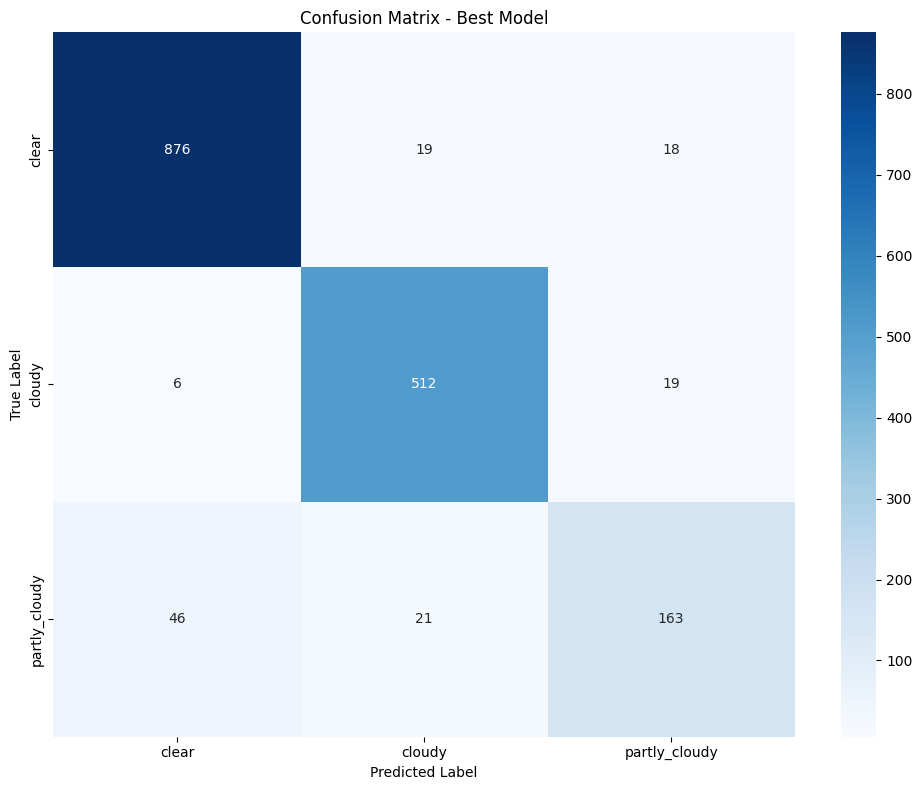


✓ Model saved to cloud_model_38cloud.pkl

Generating Feature Importance Plot...


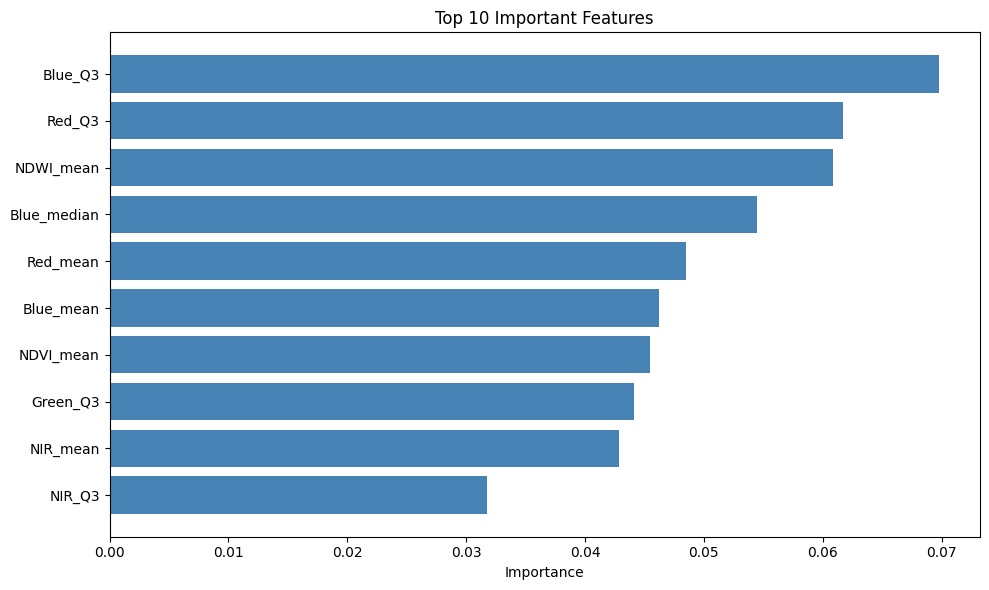


Top 10 Features:
Blue_Q3             : 0.0697
Red_Q3              : 0.0617
NDWI_mean           : 0.0608
Blue_median         : 0.0544
Red_mean            : 0.0485
Blue_mean           : 0.0462
NDVI_mean           : 0.0455
Green_Q3            : 0.0441
NIR_mean            : 0.0429
NIR_Q3              : 0.0317

✓ TRAINING COMPLETED SUCCESSFULLY!


In [40]:
if __name__ == "__main__":
    main()

✓ Saved spectral_bands_visualization.png


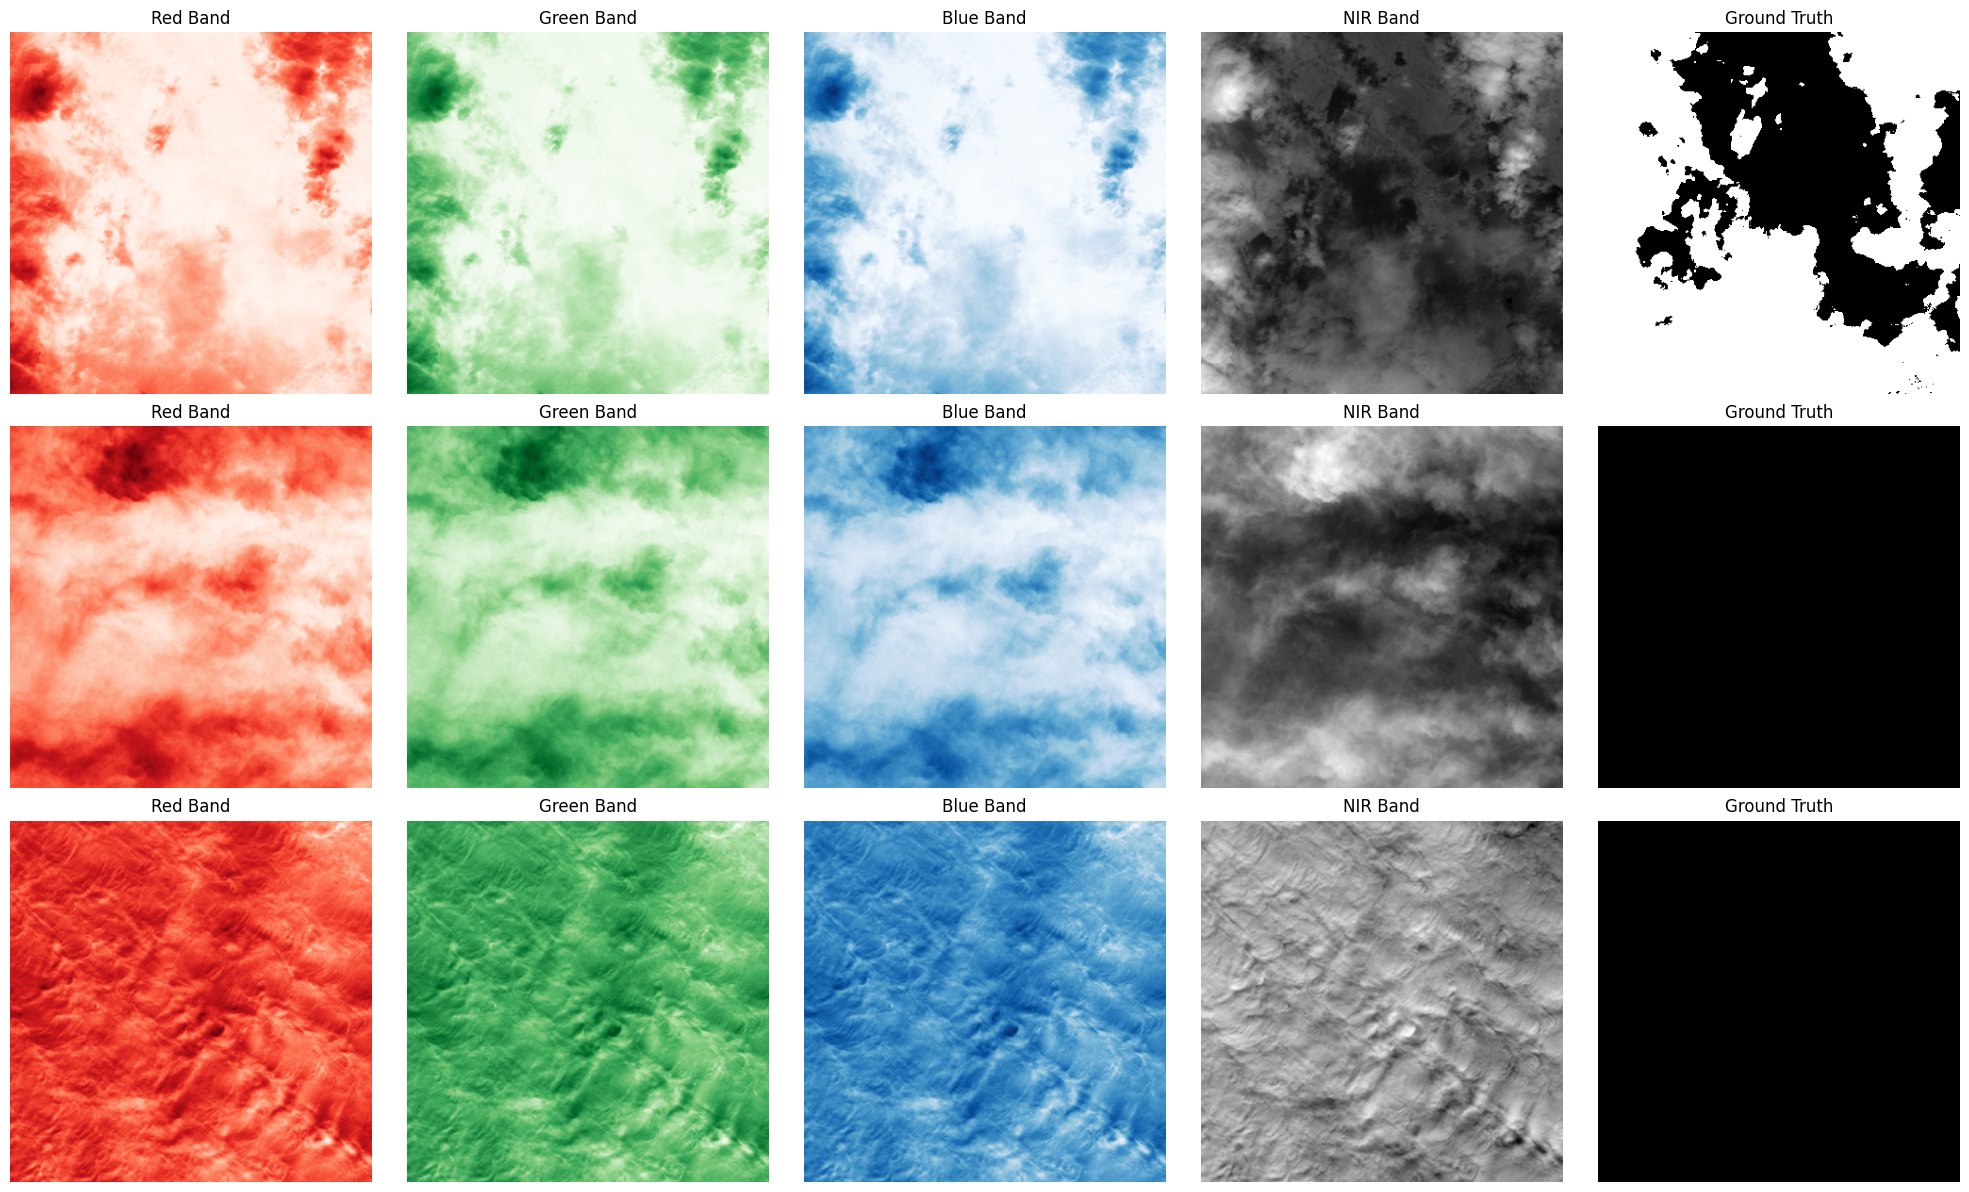

In [36]:
import matplotlib.pyplot as plt
import numpy as np

def save_sample_visualizations(predictor, num_samples=3):
    """Create figure showing different patch types"""
    
    # Load some sample patches
    train_folder = predictor.data_path / '38-Cloud_training'
    red_folder = train_folder / 'train_red'
    patches = list(red_folder.glob('*.TIF'))[:num_samples]
    
    fig, axes = plt.subplots(num_samples, 5, figsize=(20, 12))
    
    for idx, patch_name in enumerate(patches):
        ms_img, gt = predictor.load_multispectral_patch(patch_name.name, is_train=True)
        
        if ms_img is None or gt is None:
            continue
            
        # Show all 4 bands + ground truth
        axes[idx, 0].imshow(ms_img[:,:,0], cmap='Reds')
        axes[idx, 0].set_title('Red Band')
        axes[idx, 0].axis('off')
        
        axes[idx, 1].imshow(ms_img[:,:,1], cmap='Greens')
        axes[idx, 1].set_title('Green Band')
        axes[idx, 1].axis('off')
        
        axes[idx, 2].imshow(ms_img[:,:,2], cmap='Blues')
        axes[idx, 2].set_title('Blue Band')
        axes[idx, 2].axis('off')
        
        axes[idx, 3].imshow(ms_img[:,:,3], cmap='gray')
        axes[idx, 3].set_title('NIR Band')
        axes[idx, 3].axis('off')
        
        axes[idx, 4].imshow(gt, cmap='gray')
        axes[idx, 4].set_title('Ground Truth')
        axes[idx, 4].axis('off')
    
    plt.tight_layout()
    plt.savefig('spectral_bands_visualization.png', dpi=300, bbox_inches='tight')
    print("✓ Saved spectral_bands_visualization.png")
    plt.show()

# Create a new predictor instance
DATA_PATH = r"C:\Users\ramya\Desktop\data science\predictive analysis\project CA2\archive (1)"
predictor = CloudCoverPredictor38(DATA_PATH, image_size=(128, 128))

# Generate visualizations
save_sample_visualizations(predictor, num_samples=3)
